In [1]:
# native party libraries
from collections import Counter
from time import time, sleep
import os

# 3rd party libraries 
import pandas as pd
import numpy as np
from ipyparallel import Client
import ipyparallel

# load models of varying complexity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# import warnings
# import sklearn.exceptions
# warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# 3rd party classes 
from  cross_val_tool_with_PARALLEL import cross_validation_with_PARALLEL as cross_validation
from cross_val_tool_with_PARALLEL import score_model
from helper_functions import load_data

%matplotlib inline

----
# Building Machine Learning Engineering Tools

The focus of this article is to show how a custom built machine learning tool can help make the model building and validation workflow very easy. 

This is done by abstracting away all the cross validation and plotting functionality with a reusable class. Also, this class allows us to train and score these models in parallel. Lastly, we'll show how and why using learning curves to assess model perforamnce is highly benefitical. 

As a case study, we'll be using a Cellular Service Provider data set. We are tasked with building a model that can identify users who are predicted to churn. Naturally in subscription based services, these data sets are unbalanced since most users don't cancel their subscription on any given month. 

Let's see how this tool can help us achieve our goal!

-----

### Custom Built Learning Cruve Tool

We are going to be using a learning curve tool that is an improvement on the [Sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html). 

This custom tool is an improvment in the following way. 

While cross validating our model, it scores the model on 4 classification metrics (Accuracy, Precision, Recall, and F1 Score). The Sklearn version scores the model on only a single metric. Which means that we'd have to cross validate our model several times on the same data in order to get scores for all 4 metircs -- which is not a very intelligent way of doing things. Also, this tool has a method that plots the learning curves of all 4 metrics for you. Pretty useful!



```python
cv = cross_validation(model,                 # classification model
                      X_train,               # Training Predictors
                      Y_train ,              # Training Target
                      n_splits=10,           # Number of KFold splits
                      init_chunk_size = 100, # initial size of training set
                      chunk_spacings = 25,   # number of samples to increase the training set by for each iteration 
                      average = "binary")    # score metrics need the type of classification average specified (binary or multi-class)


```

#### How this tool works

1. Take the number of samples from the training set as specified in init_chunk_size
2. Perform n_splits on the data
3. Score the model on the test folds and average the scores across all the folds
5. Score the model on the training set and average the scores across all the folds
4. Store the metric's average scores in a list for the training and test folds
5. Increase the training set size by the number specified in chunk_spacings
6. Repead steps 2 through 5 until all training points are included in the training set
7. Call the `plot_learning_curve` method to visualize the results

We'll revist how this tool works with an example.

In [2]:
# abstract away irrelavent details 
df = load_data()

In [3]:
# the data has been pre-processed so we can focus on the modeling building 
df.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
0,25.0,265.1,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,1.0,False,True,False
1,26.0,161.6,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,1.0,False,True,False
2,0.0,243.4,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,0.0,False,False,False
3,0.0,299.4,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,2.0,True,False,False
4,0.0,166.7,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,3.0,True,False,False


In [4]:
# split predictors from response variable
Y_churn = df.Churn.values
X_churn = df[df.columns[:-1]].values

In [5]:
# check label balance
Counter(Y_churn)

Counter({False: 2850, True: 483})

In [6]:
# accuracy for guessing the majoirty class every time
navie_baseline = (Y_churn.shape[0] - Y_churn.sum())/ Y_churn.shape[0]
navie_baseline

0.85508550855085508

Clearly the classes are unbalanced. Our hypothesis is that this unbalancing is going to negatively affect the performance of our model by biasing the model's performance in favor of the majority class. 

Wouldn't it be nice if we had a easy to read visualiation to help analyze the model's perforamance and test our hypothesis?

That's exactly what our tool does best!

-----
### Logistic Regression

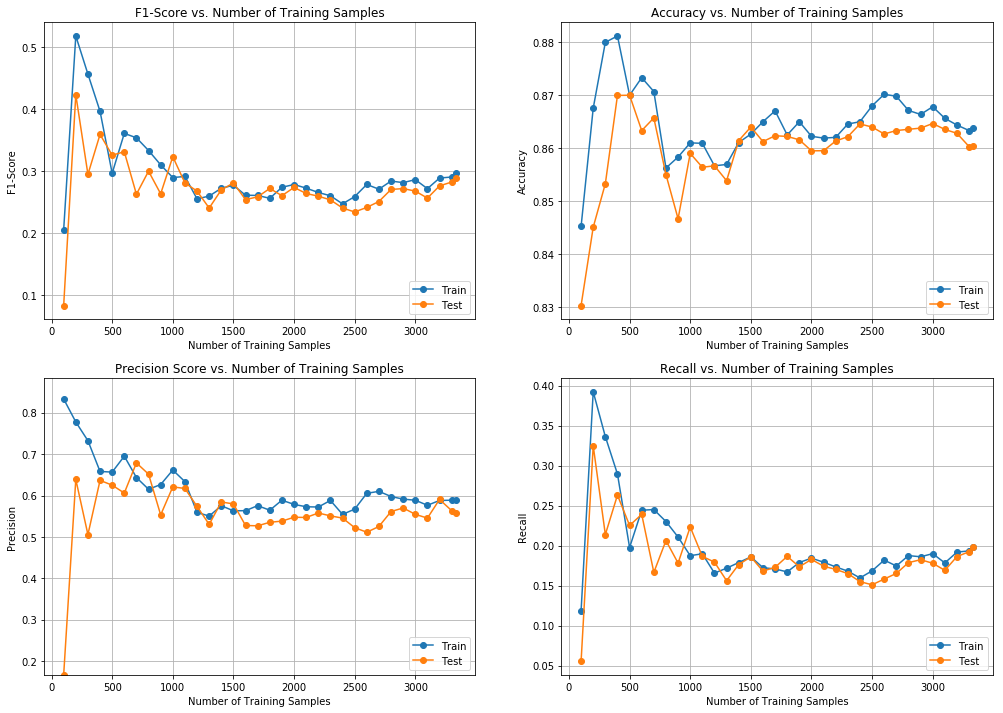

In [7]:
# create model 
lr = LogisticRegression(penalty='l2')

# initialize ml tool 
cv = cross_validation(lr, 
                      X_churn, 
                      Y_churn, 
                      average='binary',
                      init_chunk_size=100, 
                      chunk_spacings=100,
                      n_splits=3)

# call method for model training
cv.train_for_learning_curve()

# call method for ploting model results
cv.plot_learning_curve()

Let's make sure we understand what's going on. 

Each point on the train and test curves represents an average score for the metric calculated from the K-Folds that we specified. 

Notice that each Training score has a corresponding Test score point direclty under it (or in some cases direclty above it). That's because we are scoring the model on both the training and test sets to see how the model compares between the two. This will enable us to answer questions about Bias and Variance. So let's go ahead and do just that!

Notice that the Accuracy for the test set peaks at 87%, not that great considering that that Navie Accuracy is 85%. But wait, we also see that Precison peaks in the high 50%'s and Recall for the test set is peaking at about 33% -- why is that?!

Well, remember that the labels are horribly imbalanced. 

And that the metric Recall is a measure of a model's ability to correclty distinguish between different classes. Since the labels are horribly imbalanced, the relatively high Accuracy and low Recalls actually make sense. There is relatively high Accuracy because the model had pleny of Negative cases to train on, but Recall is low because the model didn't have enough Positive cases to train on and therefore learn how to distingush between the two. Precision is essentially random: of all the users that predicted to churn, only half of those actually churn. 

The learning curves also shows us that no matter how many points we include in the training set, the model will not continue to learn, i.e. improve it's performance. We can see that from the flatlining in each metric's results. This means that our model is underfitting. 

Now wasn't that an easy analysis to run with the help of this tool?!? All we had to do was pass in the model, the training data, and a few parameters and the machine leanring workflow is taken care of for us. 

Talk about efficient use of time!

----
### Random Forest

Base on our previous results, we concluded that we need to use a more complex model. Random Forest is a good choice. 

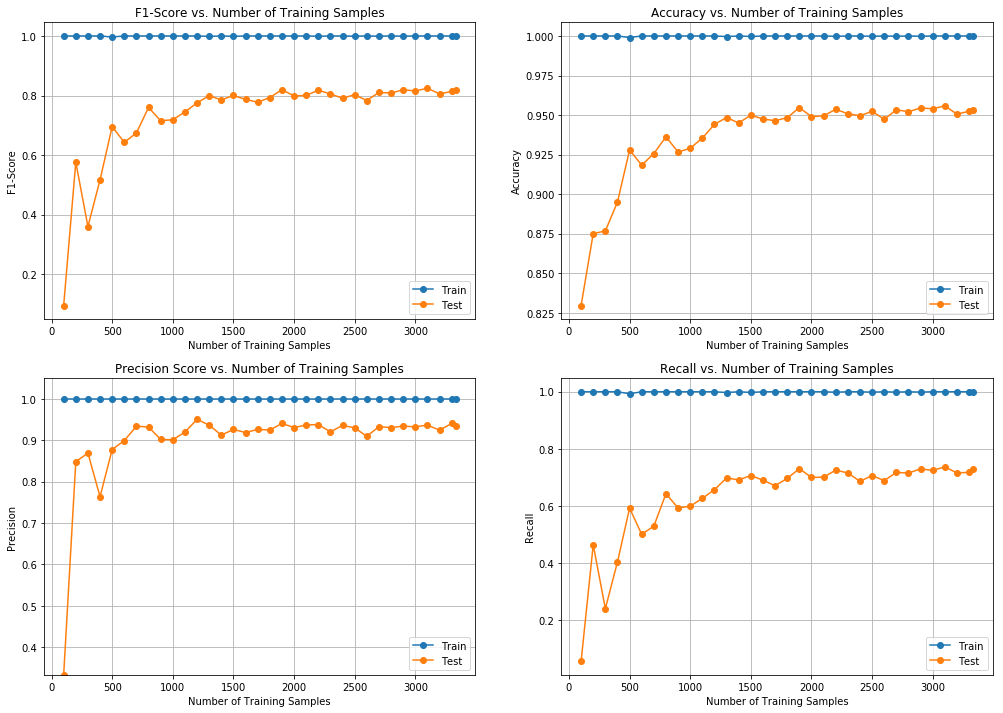

In [10]:
# create model
rfc = RandomForestClassifier(n_estimators=100, 
                             criterion='entropy', 
                             n_jobs=-1)
# initialize ml tool 
cv_rfc = cross_validation(rfc, 
                      X_churn, 
                      Y_churn, 
                      average='binary',
                      init_chunk_size=100, 
                      chunk_spacings=100,
                      n_splits=3)

# call method for model training
cv_rfc.train_for_learning_curve()

# call method for ploting model results
cv_rfc.plot_learning_curve()

Let's compare how an out-of-the-box Random Forest perforamnces to our Logistic Regression. 

We can see that the Accuracy jumps up to 95%, the Recall to about 78%, and the Precison to about 94%. 

We can of course attribute this performance to Random Forest's architecture, ie. ensemble trees and bootstrap aggragation. 

More importantly, we can see from the learning curves that the model's performances saturates at a training set size of about 1,500 and there is very little overfitt: the train and test Accuracy and Precision scores are very, very close, though there is a big gap between the two for Recall. 

So what do these results mean?

When taken together, Recall tells us that only about 7 out of 10 churners can be distinguished from non-churners and Precison tell us that of those 7 churners, about 9 out of 10 of them will be correctly classifed as churners. 

So how do we proceed?

Well, let's say that for our business goals, these results are not good enough; it's still too costly for us to be this wrong in our predictions. Ok, well we have a few  options: we can improve the model with a gridsearch, train different models, or we can improve the data. 

Given that Random Forest is overfitting on the Recall metric, this suggest that a more complex model will only lead to more overfiting and a less complex model (i.e. Logistic Regression) will lead to underfitting. So this means that we need to improve the data. For that, an obvious place to start is with the class imbalance. 

Notice how effortless our analysis is when our Machine Learning pipeline is efficient? We can spend less time on coding the infrustructure of model builiding and focus more on the results and what course of action they suggest. 



----
## Using Parallel Processing

In practice, we would be directing our focus to balancing the classes. Here, however, we are going to move ahead with a more complex model to prove the validity of a certain functinality of this tool. 

Supportive Vector Machines (SVM) generally take a long time to train. They are an excellent model to use to show the value of the parallel processing functionality of this tool. 

We simply have to pass in the number of cpus we wish to use for parallel processing, then the cross valiation class will take take of the rest!

First, to really see an effect, let's create more models to train by decreasing both the init_chunk_size and chunk_spacings to 50, and increasing n_splits to 10. Next, let's time a run with cross_validation training SVC in series. 

In [7]:
start = time()
# create model
svc = SVC(C=1.0, kernel='rbf', gamma='auto')

# initialize ml tool 
cv_svc = cross_validation(svc, 
                      X_churn, 
                      Y_churn, 
                      average='binary',
                      init_chunk_size=50, 
                      chunk_spacings=50,
                      n_splits=10)

# call method for model training
cv_svc.train_for_learning_curve()
end = time()

print("Time Elapsed {:.3}".format(end - start))

Time Elapsed 64.1


Now let's time a run with cross_validation training a SVC in parallel.

In [10]:
start = time()
n_cpus = 7
# create model
svc = SVC(C=1.0, kernel='rbf', gamma='auto')

# initialize ml tool 
cv_svc = cross_validation(svc, 
                      X_churn, 
                      Y_churn, 
                      average='binary',
                      init_chunk_size=50, 
                      chunk_spacings=50,
                      n_splits=10)

# call method for model training
cv_svc.train_for_learning_curve_PARALLEL(n_cpus)
end = time()

print("Time Elapsed {:.3}".format(end - start))

Time Elapsed 26.3


What we observe is that, when trained in parallel, the training time is 33% of the training time in series. That becomes a huge time saver when we have a larger dataset. Scalibility is a hugh must have in machine leanring!

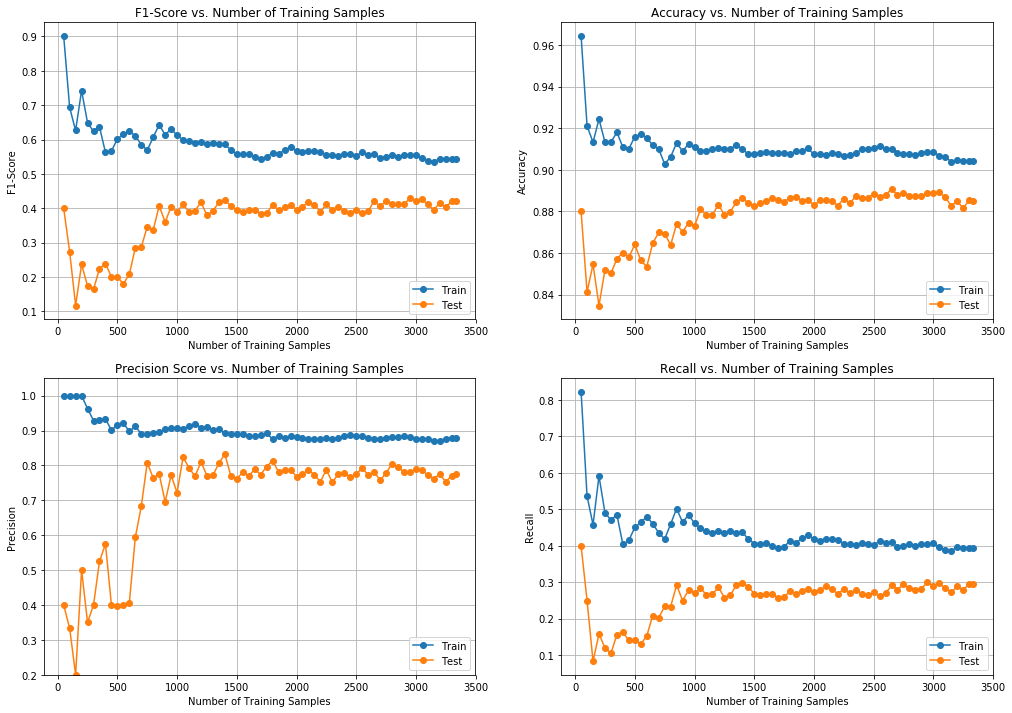

In [11]:
cv_svc.plot_learning_curve()

Lastly, just as we suspected, using a more complex (out-of-the-box) model than Random Forest has lead to more overfitting. Yikes!

-----
# Conclusion 

By using the case study of builidng a model to predict user churn, we have shown how the cross_validation data tool can be used to make the machine learning model building and validation process easy and time efficient. This is done by abstracting away all the boiler plate code around model building and simply requiring the developer to pass in the model, training data, and a few parameters. 

We also showed the value of displaying the 4 most common classification metrics on learning curves. And how they are invaluable for analyzing model erros like Bias and Varaince and spotting over-training. 

Feel free to fork this project on my Github account and let me know what you in the comments!
